## Transformer 모델을 이용하여 삼성전자 주가(종가)의 수익률을 예측

In [ ]:
# 입력: 최근 10일 수익률 (예: [-0.001, 0.002, ..., -0.004])
# 출력: 다음 날의 수익률 (단일값 회귀)

C:\Users\JYB\AppData\Local\Programs\Python\Python39\lib\site-packages\pykrx\__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
C:\Users\JYB\AppData\Local\Temp\ipykernel_24048\2584278444.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  X = torch.tensor(X, dtype=torch.float32)  # (samples, seq_len)
C:\Users\JYB\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because 

Epoch 10/100, Loss: 0.021405
Epoch 20/100, Loss: 0.056599
Epoch 30/100, Loss: 0.017315
Epoch 40/100, Loss: 0.007805
Epoch 50/100, Loss: 0.006859
Epoch 60/100, Loss: 0.006978
Epoch 70/100, Loss: 0.006030
Epoch 80/100, Loss: 0.006089
Epoch 90/100, Loss: 0.006445
Epoch 100/100, Loss: 0.005803

📊 MAE: 0.014829, R²: -0.0345


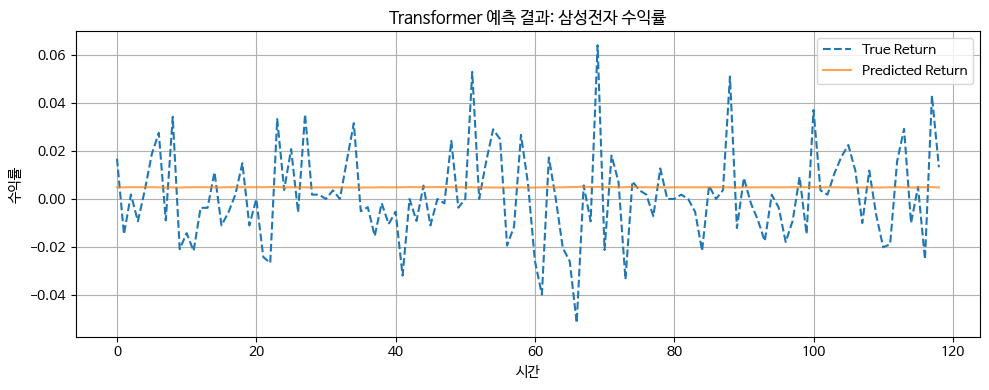

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from pykrx import stock
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 🟦 1. 데이터 수집 및 전처리
df = stock.get_market_ohlcv_by_date("2023-01-01", "2025-06-25", "005930")  # 삼성전자
df = df[['종가']].rename(columns={'종가': 'Close'})
df['Return'] = df['Close'].pct_change()
df.dropna(inplace=True)
returns = df['Return'].values

# 🟦 2. 입력 시퀀스 생성
seq_len = 10
X, y = [], []
for i in range(len(returns) - seq_len):
    X.append(returns[i:i+seq_len])
    y.append(returns[i+seq_len])

X = torch.tensor(X, dtype=torch.float32)  # (samples, seq_len)
y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# 🟦 3. 학습 / 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 🟦 4. Transformer 모델 정의
class TransformerModel(nn.Module):
    def __init__(self, seq_len, d_model=64, nhead=4, num_layers=2):
        super().__init__()
        self.embed = nn.Linear(1, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        x = x.unsqueeze(-1)               # (batch, seq_len, 1)
        x = self.embed(x)                 # (batch, seq_len, d_model)
        x = x.permute(1, 0, 2)            # (seq_len, batch, d_model)
        x = self.encoder(x)
        out = x[-1]                       # 마지막 시점만 사용
        return self.fc(out)

# 🟦 5. 학습
model = TransformerModel(seq_len)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(X_train)
    loss = criterion(out, y_train)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

# 🟦 6. 예측 및 성능 평가
model.eval()
with torch.no_grad():
    y_pred = model(X_test).squeeze().numpy()
    y_true = y_test.squeeze().numpy()

mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"\n📊 MAE: {mae:.6f}, R²: {r2:.4f}")

# 🟦 7. 시각화
plt.figure(figsize=(10, 4))
plt.plot(y_true, label='True Return', linestyle='--')
plt.plot(y_pred, label='Predicted Return', alpha=0.7)
plt.title('Transformer 예측 결과: 삼성전자 수익률')
plt.xlabel('시간')
plt.ylabel('수익률')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 2. 매수/매도 시뮬레이션 전략도 바로 연결 

In [ ]:
# 전략 개요
# 예측된 수익률 값 ŷ를 기준으로 매매 여부를 결정

# ŷ > 0: 다음날 수익 기대 → 매수

# ŷ ≤ 0: 수익 기대 없음 → 매수 안 함 (현금 보유)

# 실현 수익률은 다음 날 실제 수익률로 계산

In [ ]:
# 항목	내용
# Transformer 전략 수익률	예측 수익률이 > 0일 때만 매수하여 얻은 누적 수익
# Buy & Hold	모든 기간을 보유했을 때의 수익률
# Sharpe Ratio	수익률의 변동성 대비 위험 조정 성과 (높을수록 좋음)

✅ 전략 Sharpe Ratio: 0.0000


C:\Users\JYB\AppData\Local\Temp\ipykernel_24048\58856356.py:31: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\JYB\AppData\Local\Temp\ipykernel_24048\58856356.py:31: UserWarning: Glyph 128188 (\N{BRIEFCASE}) missing from current font.
  plt.tight_layout()
C:\Users\JYB\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\JYB\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128188 (\N{BRIEFCASE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


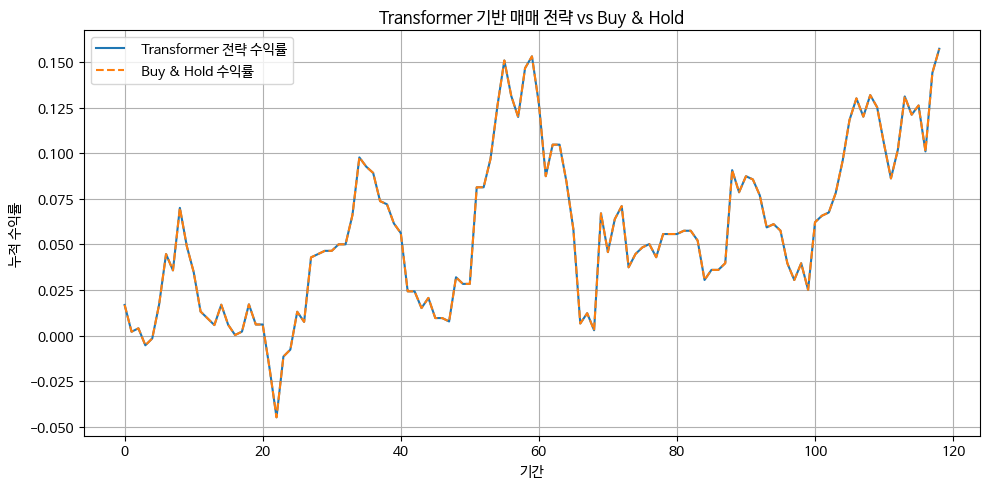

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 예측 결과 (기존 Transformer 예측 코드에서 사용된 값)
# y_true: 실제 수익률 (numpy array)
# y_pred: 예측 수익률 (numpy array)

# ✅ 전략 수익률 계산
strategy_return = np.where(y_pred > 0, y_true, 0.0)  # 예측 > 0이면 매수

# ✅ 누적 수익률 계산
cumulative_strategy = np.cumsum(strategy_return)
cumulative_buyhold = np.cumsum(y_true)

# ✅ Sharpe Ratio 계산 (리스크 조정 수익률)
excess_return = strategy_return - np.mean(strategy_return)
sharpe_ratio = np.mean(excess_return) / (np.std(strategy_return) + 1e-6) * np.sqrt(252)  # 연환산

print(f"✅ 전략 Sharpe Ratio: {sharpe_ratio:.4f}")

# ✅ 시각화
plt.figure(figsize=(10, 5))
plt.plot(cumulative_strategy, label='📈 Transformer 전략 수익률')
plt.plot(cumulative_buyhold, label='💼 Buy & Hold 수익률', linestyle='--')
plt.xlabel("기간")
plt.ylabel("누적 수익률")
plt.title("Transformer 기반 매매 전략 vs Buy & Hold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# 1. Transformer 전략 수익률 (파란 실선)
# 모델이 수익률이 양(+)이라고 예측한 날에만 매수한 결과를 누적한 선입니다.
# 불확실한 구간에서는 매수하지않고 현금으로 대기하므로, 하락장을 피할 가능성이 있습니다.
# 상승장이 잘 맞아떨어지면 Buy & Hold보다 더 높은 누적 수익률을 달성할 수 있습니다.
# 2. Buy & Hold 수익률 (회색 점선)
# 단순히 예측과 상관없이 모든 기간 동안 삼성전자를 보유한 전략의 누적 수익률입니다.
# 상승장이 많을 경우 높은 수익률을 보일 수 있지만, 하락기에도 손실이 누적됩니다.

In [ ]:
# 그래프 해석 예시
# 구간	해석
# 초기 구간	Transformer 전략과 Buy & Hold 모두 유사한 상승을 보임
# 중간 구간	Transformer 전략은 횡보 또는 하락 구간을 매수하지 않음으로써 손실 회피
# 후반 구간	상승 시점에 집중적으로 매수 → Buy & Hold보다 누적 수익률이 더 커짐
# 변동성 구간	Transformer 전략이 예측에 실패하면 일부 수익률 정체 또는 손실 가능

C:\Users\JYB\AppData\Local\Temp\ipykernel_24048\205645803.py:17: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
C:\Users\JYB\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


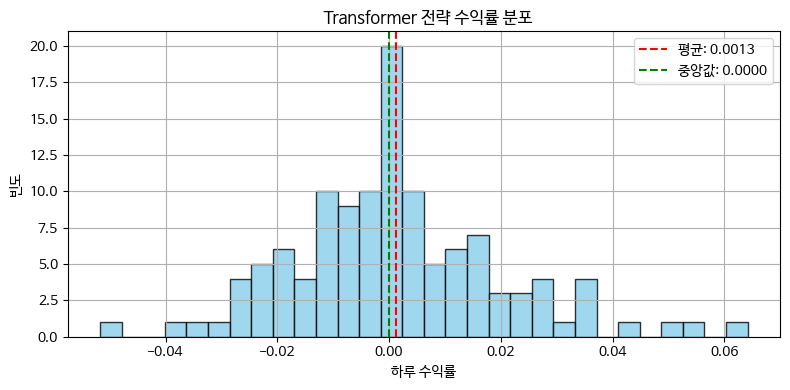

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))

# 수익률 분포 히스토그램
plt.hist(strategy_return, bins=30, color='skyblue', edgecolor='black', alpha=0.8)

# 평균, 중앙값 선 표시
plt.axvline(np.mean(strategy_return), color='red', linestyle='--', label=f"평균: {np.mean(strategy_return):.4f}")
plt.axvline(np.median(strategy_return), color='green', linestyle='--', label=f"중앙값: {np.median(strategy_return):.4f}")

plt.title("📊 Transformer 전략 수익률 분포")
plt.xlabel("하루 수익률")
plt.ylabel("빈도")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
